In [284]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


l_h = 0
l_s = 0
l_v = 0
u_h = 255
u_s = 255
#Day
# u_v = 108
#Night
u_v = 90

lower = np.array([l_h, l_s, l_v])
upper = np.array([u_h, u_s, u_v])

In [285]:
def show_image_fixed(img, title="", is_bgr=True, is_gray=False, zoom=1.0, step=25):
    height, width = img.shape[:2]
    figsize = (width * zoom / 50, height * zoom / 50)

    plt.figure(figsize=figsize)
    if is_gray:
        plt.imshow(img, cmap='gray')
    elif is_bgr:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img)

    plt.title(title)
    plt.xticks(np.arange(0, width, step))
    plt.yticks(np.arange(0, height, max(height // 20, 1)))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

def plot_histogram_full_width(histogram, image_width, zoom=1.0, step=50):
    height = 600  # pixel, chỉ là chiều cao cho dễ nhìn
    figsize = (image_width * zoom / 50, height * zoom / 100)

    plt.figure(figsize=figsize)
    plt.plot(np.arange(len(histogram)), histogram, color='blue', linewidth=1.5)
    plt.title('Histogram theo chiều rộng ảnh', fontsize=14)
    plt.xlabel('Vị trí cột (pixel)', fontsize=12)
    plt.ylabel('Tổng pixel', fontsize=12)
    plt.xticks(np.arange(0, image_width, step))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [286]:
def canny(image):
    roi = image[520:720, :]
    hsv_transformed_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_transformed_frame, lower, upper)
    blur = cv2.GaussianBlur(mask, (5, 5), 0)
    edges = cv2.Canny(blur, 10, 150)

    # Hiển thị từng bước
    show_image_fixed(roi, "Step 1 - ROI")
    show_image_fixed(hsv_transformed_frame, "Step 2 - HSV", is_bgr=False)
    show_image_fixed(mask, "Step 3 - Mask", is_gray=True)
    show_image_fixed(blur, "Step 4 - Gaussian Blur", is_gray=True)
    # show_image_fixed(edges, "Step 55 - Edges", is_gray=True)

    return blur

In [287]:
def find_center_road(image):
    histogram = np.sum(image, axis=0)  

    plot_histogram_full_width(histogram, image_width=image.shape[1], zoom=1, step=25)

    max_length = 0  # Đoạn dài nhất
    current_length = 0  # Chiều dài của đoạn hiện tại
    start_index = 0  # Vị trí bắt đầu của đoạn dài nhất
    end_index = 0  # Vị trí kết thúc của đoạn dài nhất
    start_index_secondary = 0
    end_index_secondary = 0
    max_length_secondary = 0

    for i in range(0, 1279):
        if (histogram[i] < 3000):
            if current_length == 0:
                start_index_tmp = i  # Lưu lại vị trí bắt đầu của đoạn mới
            current_length += 1
        else:
            if current_length > max_length:
                max_length_secondary = max_length
                start_index_secondary = start_index
                end_index_secondary = end_index  # Đoạn kết thúc tại chỉ số trước cột này
                max_length = current_length
                start_index = start_index_tmp
                end_index = i - 1  # Đoạn kết thúc tại chỉ số trước cột này
            elif current_length > max_length_secondary:
                max_length_secondary = current_length
                start_index_secondary = start_index_tmp
                end_index_secondary = i - 1  # Đoạn kết thúc tại chỉ số trước cột này
            current_length = 0

    # Kiểm tra nếu đoạn cuối cùng là dài nhất
    if current_length > max_length:
        max_length = current_length
        start_index = start_index_tmp
        end_index = len(histogram) - 1
    elif current_length > max_length_secondary:
        max_length_secondary = current_length
        start_index_secondary = start_index_tmp
        end_index_secondary = i  # Đoạn kết thúc tại chỉ số trước cột này

    center = (start_index + end_index)//2
    center_secondary = (start_index_secondary+end_index_secondary)//2
    
    return center, center_secondary

In [288]:
def find_nearest_white_points(edge_image, x_ref, y_ref):
    y = y_ref -520  
    row_pixels = edge_image[y, :]  # Lấy toàn bộ dòng y cần detect
    
    # Tìm các vị trí x có giá trị 255 (trắng)
    white_x_positions = np.where(row_pixels == 255)[0]

    if len(white_x_positions) == 0:
        print("Không tìm thấy điểm trắng nào trên hàng này.")
        return 0, 1279

    # Tách điểm bên trái và bên phải x_ref
    left_points = [x for x in white_x_positions if x < x_ref]
    right_points = [x for x in white_x_positions if x > x_ref]

    # Lấy điểm gần nhất bên trái và bên phải
    x_left = max(left_points) if left_points else 0
    x_right= min(right_points) if right_points else 1279

    return x_left, x_right

In [289]:
def find_angle(edge_image,y_down, y_up, center, center_secondary):
    #tìm 4 điểm thuộc lane
    x_left_1, x_right_1 = find_nearest_white_points(edge_image, center, y_down)
    x_left_2, x_right_2 = find_nearest_white_points(edge_image, center, y_up)
    if ((x_left_1 == 0)|(x_left_2==0))&(x_right_1<x_right_2):
        x_left_1, x_right_1 = find_nearest_white_points(edge_image, center_secondary, y_down)
        x_left_2, x_right_2 = find_nearest_white_points(edge_image, center_secondary, y_up)
    elif ((x_right_1 == 1279)|(x_right_2 == 1279))&(x_left_1 > x_left_2):
        x_left_1, x_right_1 = find_nearest_white_points(edge_image, center_secondary, y_down)
        x_left_2, x_right_2 = find_nearest_white_points(edge_image, center_secondary, y_up)
    
    #tìm điểm trung tâm
    x_center = (x_left_1 + x_right_1)/2
    x_up = (x_left_2 + x_right_2)/2

    #tính toán góc
    tan = (x_center- x_up)/(y_down-y_up)
    angle = np.arctan(tan)*180/3.1415
    return angle, x_center, x_left_1, x_right_1, x_left_2, x_right_2

In [290]:
def cv_process(img):
    canny_image = canny(img) 
    center, center_secondary = find_center_road(canny_image)
    return find_angle(canny_image, 719, 520, center, center_secondary)

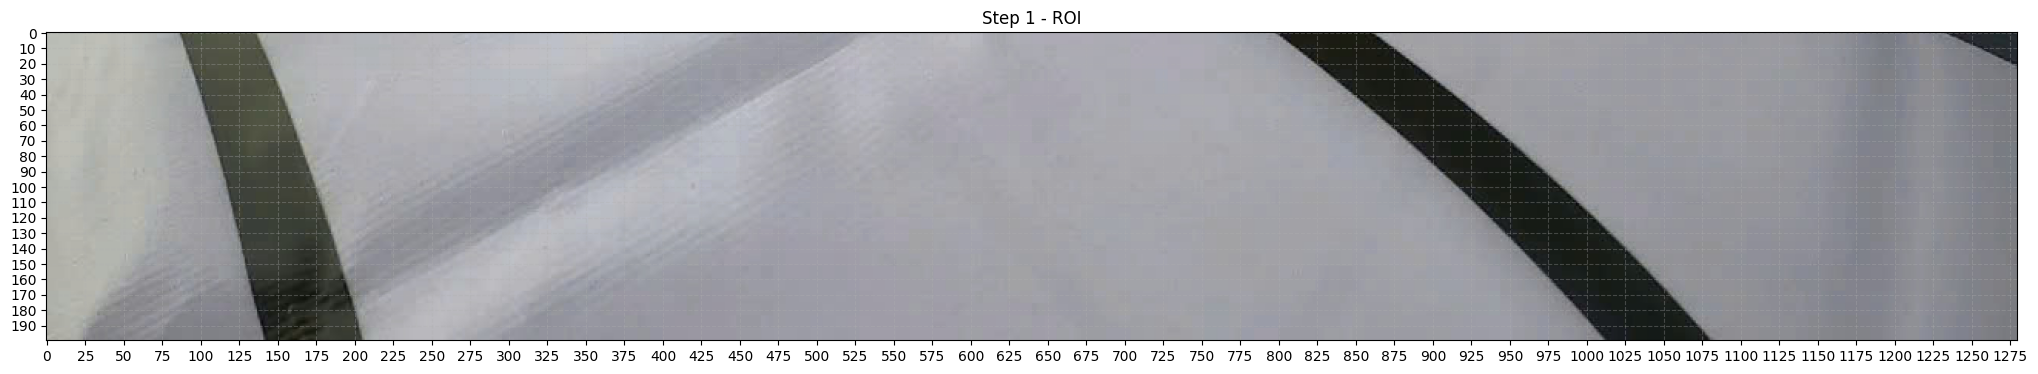

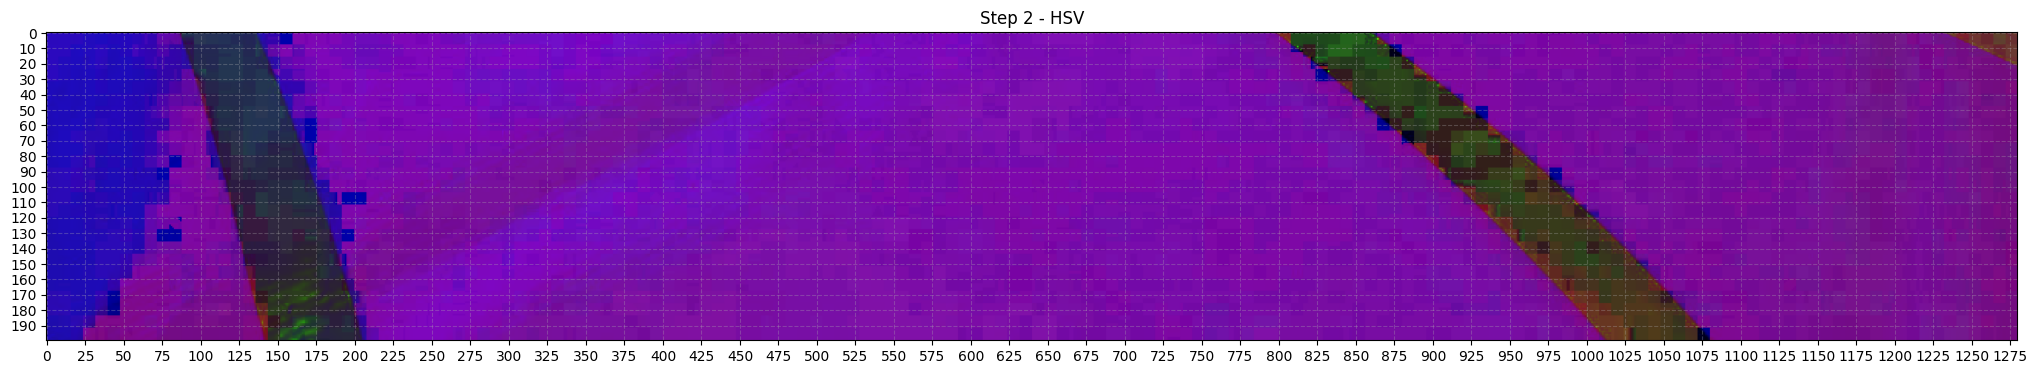

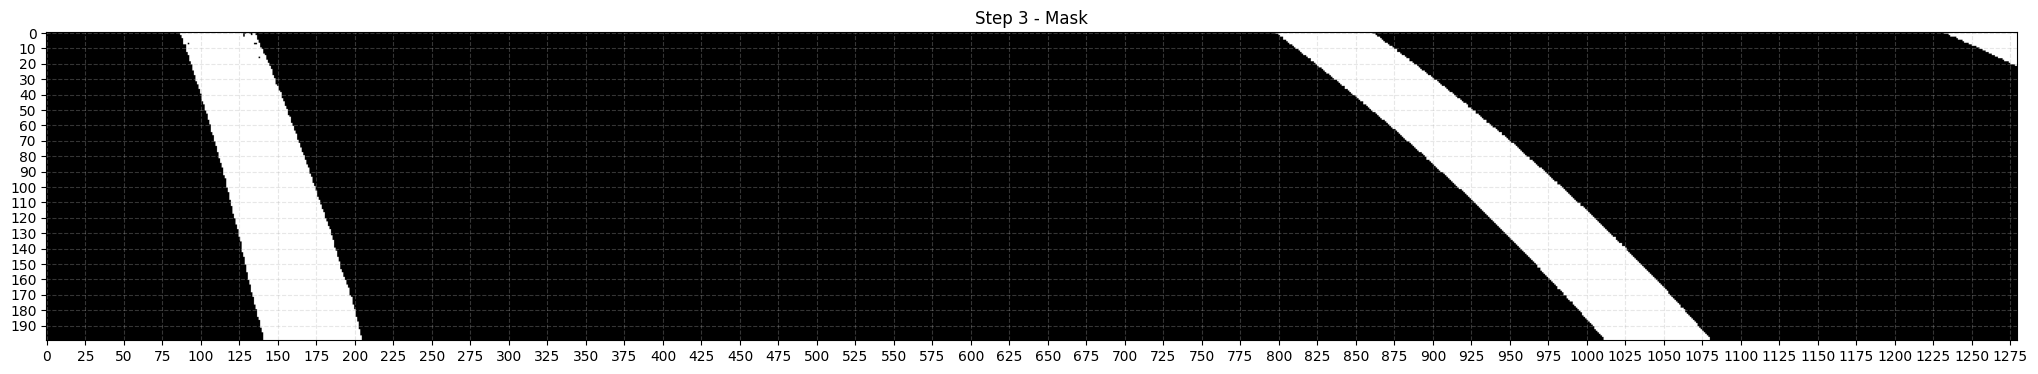

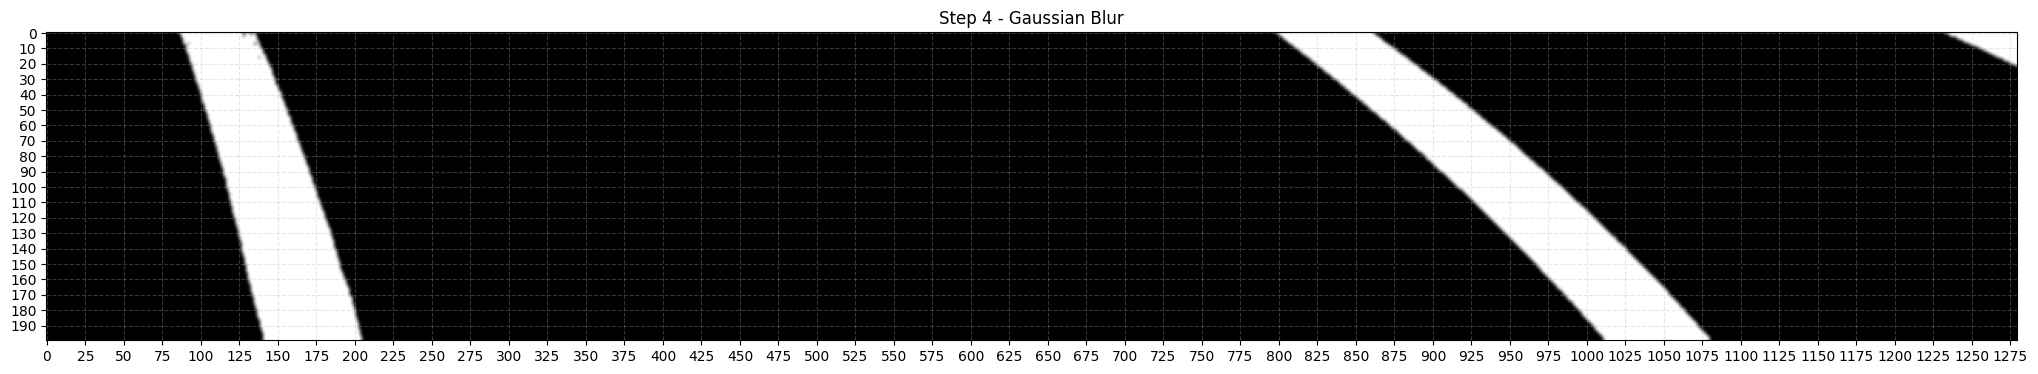

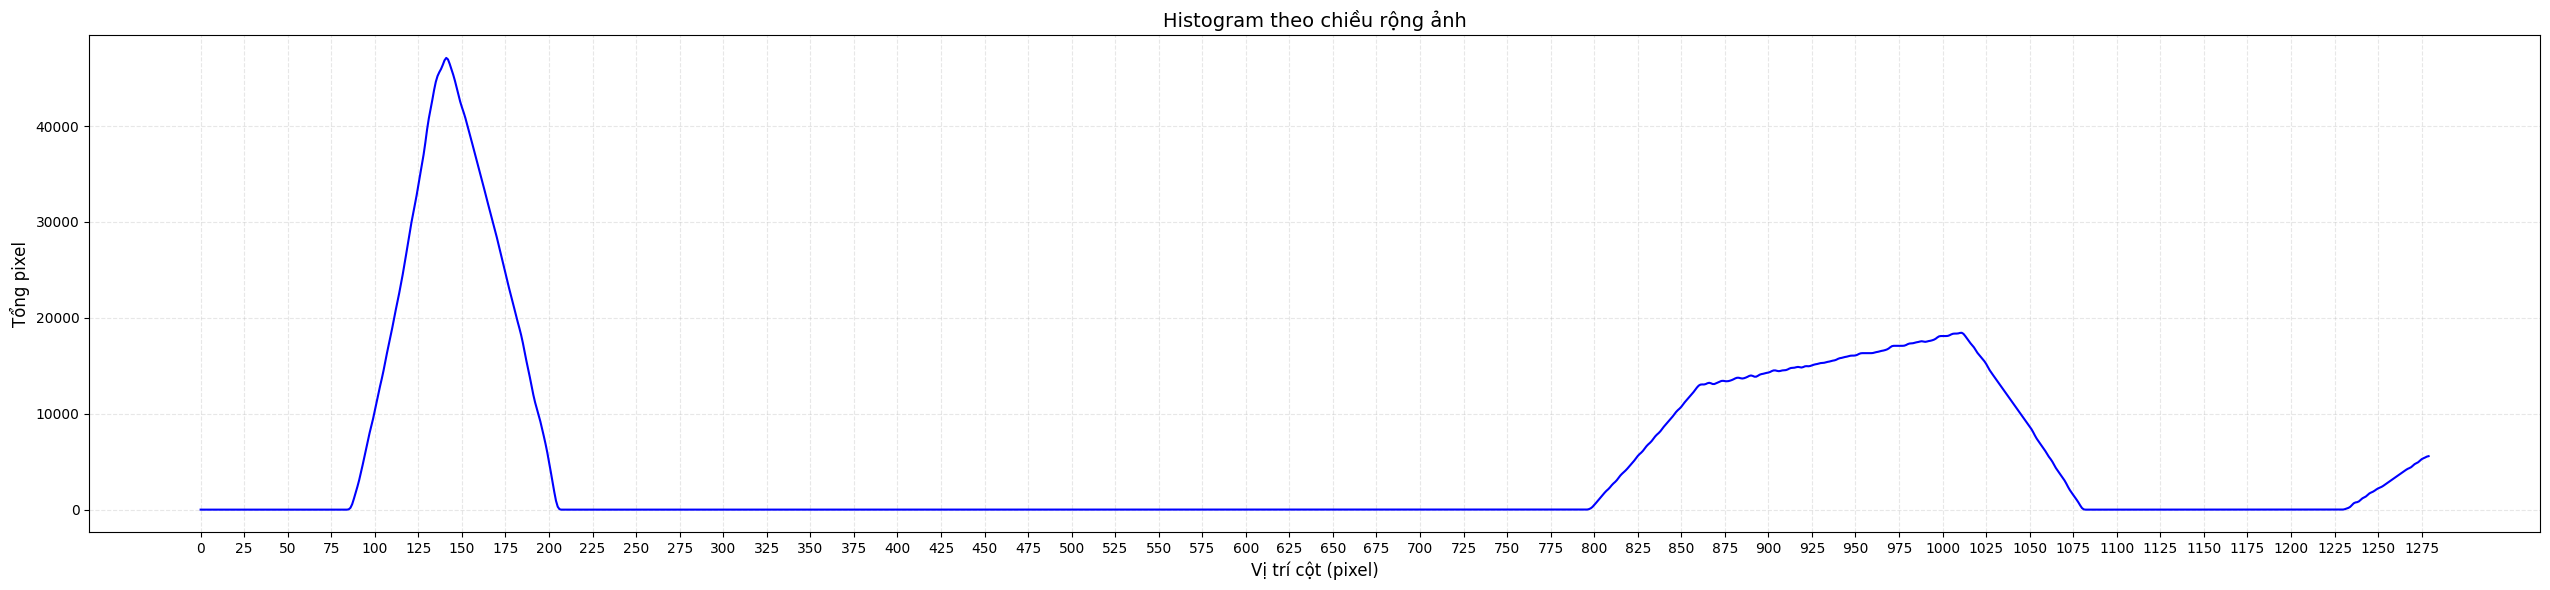

Angle: 35.79663744908527
Center: 607.5
Left1: 202
Right1: 1013
Left2: 125
Right2: 803


In [291]:
image = cv2.imread("r_frame_008.jpg")
angle, x_center, x_left_1, x_right_1, x_left_2, x_right_2 = cv_process(image)
print("Angle: {}\nCenter: {}\nLeft1: {}\nRight1: {}\nLeft2: {}\nRight2: {}".format(
angle, x_center, x_left_1, x_right_1, x_left_2, x_right_2))